In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_att_losses"]["values"], axis=1)]))
    return all_vals

In [66]:
noprior_vals = print_validation_profile_and_prior_losses("ATAC/A549")

Best profile loss overall:
	Best run: 2
	Best epoch in run: 6
	Associated value: 32860.378459323925
Best epoch in each run:
	Run 1, epoch 5: 33233.75
	Run 2, epoch 6: 32860.38
	Run 3, epoch 5: 33104.19
	Run 4, epoch 7: 33327.95
	Run 5, epoch 6: 32880.38
	Run 6, epoch 4: 33061.09
	Run 7, epoch 5: 33048.38
	Run 8, epoch 7: 32988.43
	Run 9, epoch 7: 33145.20
	Run 10, epoch 4: 33011.23
All validation profile and prior losses:
1
	37117.23 33264.01 32285.28 31680.12 31221.30 30872.30 30601.36 30366.47 30165.29 29980.59
	34548.90 33558.57 33247.28 33393.79 33233.75 33317.79 33373.54 33253.93 33314.38 33638.90
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
2
	37627.17 33363.81 32287.71 31662.00 31210.07 30848.54 30537.40 30297.78 30093.72 29923.85
	35163.63 33828.07 33111.24 33403.28 33552.62 32860.38 32897.82 33395.88 33136.21 33203.17
	0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000
3
	37409.34 33555.89 32393.70 31812.99 31360.36 30998.40 30726.4

In [70]:
prior_vals = print_validation_profile_and_prior_losses("ATAC/A549_prior")

Best profile loss overall:
	Best run: 2
	Best epoch in run: 5
	Associated value: 32748.62573133358
Best epoch in each run:
	Run 1, epoch 9: 32930.87
	Run 2, epoch 5: 32748.63
	Run 3, epoch 8: 33361.37
	Run 4, epoch 10: 33239.00
	Run 5, epoch 8: 32989.33
	Run 6, epoch 3: 33343.74
All validation profile and prior losses:
1
	36942.56 33374.96 32458.83 31995.86 31623.62 31331.50 31062.66 30879.92 30696.57 30552.85
	35564.67 33504.97 33301.95 33069.21 33137.84 33248.79 32999.48 33152.16 32930.87 33079.27
	0.2562 0.2461 0.2229 0.1973 0.1868 0.1795 0.1744 0.1632 0.1691 0.1541
2
	37341.55 33380.12 32460.03 31979.71 31663.29 31373.36 31147.44 30929.66 30760.30 30627.08
	34374.31 33218.54 32873.12 32789.45 32748.63 32774.95 32993.49 32851.23 32838.32 32845.82
	0.2510 0.2214 0.2083 0.1976 0.1870 0.1742 0.1622 0.1663 0.1626 0.1671
3
	36960.53 33340.68 32389.82 31836.62 31474.22 31227.54 30990.37 30773.27 30597.12 30457.55
	35456.69 33780.18 33922.18 33899.07 34199.13 33519.56 33515.19 33361.37 337

In [68]:
prior_vals = print_validation_profile_and_prior_losses("ATAC/A549_prior_attconstant")

Best profile loss overall:
	Best run: 4
	Best epoch in run: 7
	Associated value: 33026.0779421666
Best epoch in each run:
	Run 1, epoch 6: 33162.39
	Run 2, epoch 8: 33072.65
	Run 3, epoch 6: 33064.10
	Run 4, epoch 7: 33026.08
All validation profile and prior losses:
1
	37195.81 33654.39 32821.08 32244.25 31825.06 31492.03 31239.98 31029.53 30843.30 30667.99
	34756.49 34871.70 33549.74 33774.70 33356.30 33162.39 33239.80 33622.84 33831.76 33844.03
	0.2019 0.1891 0.1815 0.1728 0.1679 0.1583 0.1582 0.1584 0.1489 0.1510
2
	37293.28 33645.31 32768.33 32144.11 31734.37 31390.63 31128.71 30897.68 30709.03 30581.41
	34990.72 34261.88 33550.63 33451.46 33419.07 33611.48 33113.25 33072.65 33353.01 33371.20
	0.2153 0.2066 0.1684 0.1740 0.1446 0.1485 0.1527 0.1501 0.1573 0.1497
3
	36988.96 33703.46 32817.21 32256.22 31847.61 31590.39 31309.95 31105.58 30879.06 30741.08
	34841.58 34211.77 33507.26 33301.71 33336.02 33064.10 33281.09 33446.61 33270.36 33466.66
	0.2031 0.1796 0.1717 0.1717 0.1610 0.1

In [19]:
import matplotlib.pyplot as plt

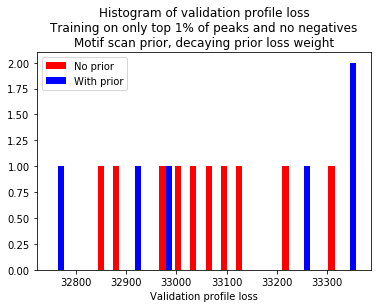

In [71]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on only top 1% of peaks and no negatives"
title += "\nMotif scan prior, decaying prior loss weight"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [36]:
import scipy.stats

In [37]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

-0.7749625918351688
0.22044974572446518
